# The Blood-Brain Barrier - A Controlled Experiment

The human brain is protected from bacteria and toxins, which course through the bloodstream, by a single layer of cells called the *blood-brain barrier*.  This barrier normally alllows only a few substances, including some medications, to reach the brain.  Because chemicals used to treat brain cells have such large molecular size, they cannot pass through the barrier to attack tumor cells.  At the Oregon Health Sciences University. Dr. E. A. Newwelt developed a method of disrupting the barrier by infusing a solution of concentrated sugars.

As a test of the disruption mechanism, researchers conducted a study on rats, which possess a similar barrier.  (Data from P. Barnett et al., "Differential Permeability and Quantitative MR Imaging of a Human Lung Carcinoma Brain Xenograft in the Nude Rat," *American Journal of Pathology* 146(2) (1995): 436-49.) . The rats were innoculated with human lung cancer cells to induce brain tumors.  After 9 to 11 days they were infused with either the barrier disruption (BD) solution or, as a control, a normal saline (NS) solution.  Fifteen minutes later, the rats received a standard dose of the therapeutic antibody $L6\mathrm{-}F(ab\prime)_2$.  After a set time they were sacrificed, and the amounts of antibody in the brain tumor and in normal tissue were measured.

Since the amount of the antibody in normal tissue indicates how much of it the rat actually received, a key measure of the effectiveness of transmission across the blood-brain barrier is the ratio of the antibody concentration in the brain tumor to the antibody concentration in normal tissue outside the brain.  The brain tumor concentration divided by the liver concentration is a measure of the amount of the antibody that reached the brain relative to the amount of it that reaeched other parts of the body.  This is the response variable.  The explanatory variables comprise two two categories:  *design variables* are those that describe manipulation by the researcher; *covariates* are those measuring characteristics of the subjects that were not controllable by the researcher.

Was the antibody concentration in the brain tumor increased by the use of the blood-brain barrier disruption infusion?  If so, by how much?  Do the answers to these two questions depend on the length of time after the infusion (from 1/2 to 72 hours)?  What is the effect of treatment on antibody concentration after weight loss, total tumor weight, and the other covariates are accounted for?

In [12]:
# standard library imports

# 3rd party library imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

sns.set()
pd.options.display.float_format = "{:.3f}".format
pd.options.display.max_columns = 12

We begin by reading the data and summarizing the variables.

In [2]:
df = pd.read_csv('case1102.csv')
df.head()

,Brain,Liver,Time,Treatment,Days,Sex,Weight,Loss,Tumor
0,41081,1456164,0.500,BD,10,Female,239,5.900,221
1,44286,1602171,0.500,BD,10,Female,225,4.000,246
2,102926,1601936,0.500,BD,10,Female,224,-4.900,61
3,25927,1776411,0.500,BD,10,Female,184,9.800,168
4,42643,1351184,0.500,BD,10,Female,250,6.000,164


In [3]:
df['Concentration'] = df['Brain'] / df['Liver']
df = df.rename(mapper={'Time': 'SAC', 'Treatment': 'TRTMNT'}, axis='columns')

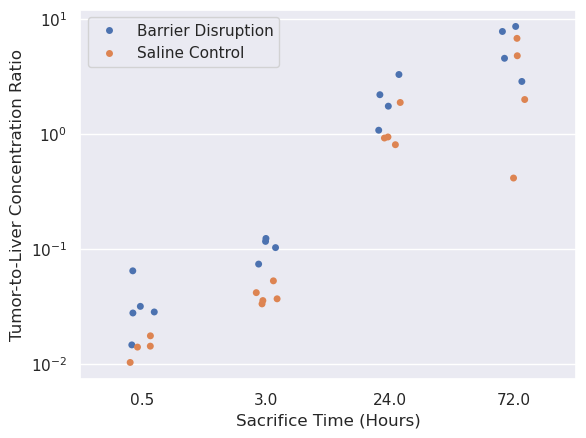

In [4]:
# This plot seems to show an effect due to the treatment.
fig, ax = plt.subplots()
_ = sns.stripplot(data=df, x='SAC', y='Concentration', hue='TRTMNT', log_scale=True, ax=ax)
_ = ax.set_xlabel('Sacrifice Time (Hours)')
_ = ax.set_ylabel('Tumor-to-Liver Concentration Ratio')
handles, labels = ax.get_legend_handles_labels()
_ = ax.legend(handles, ['Barrier Disruption', 'Saline Control'])

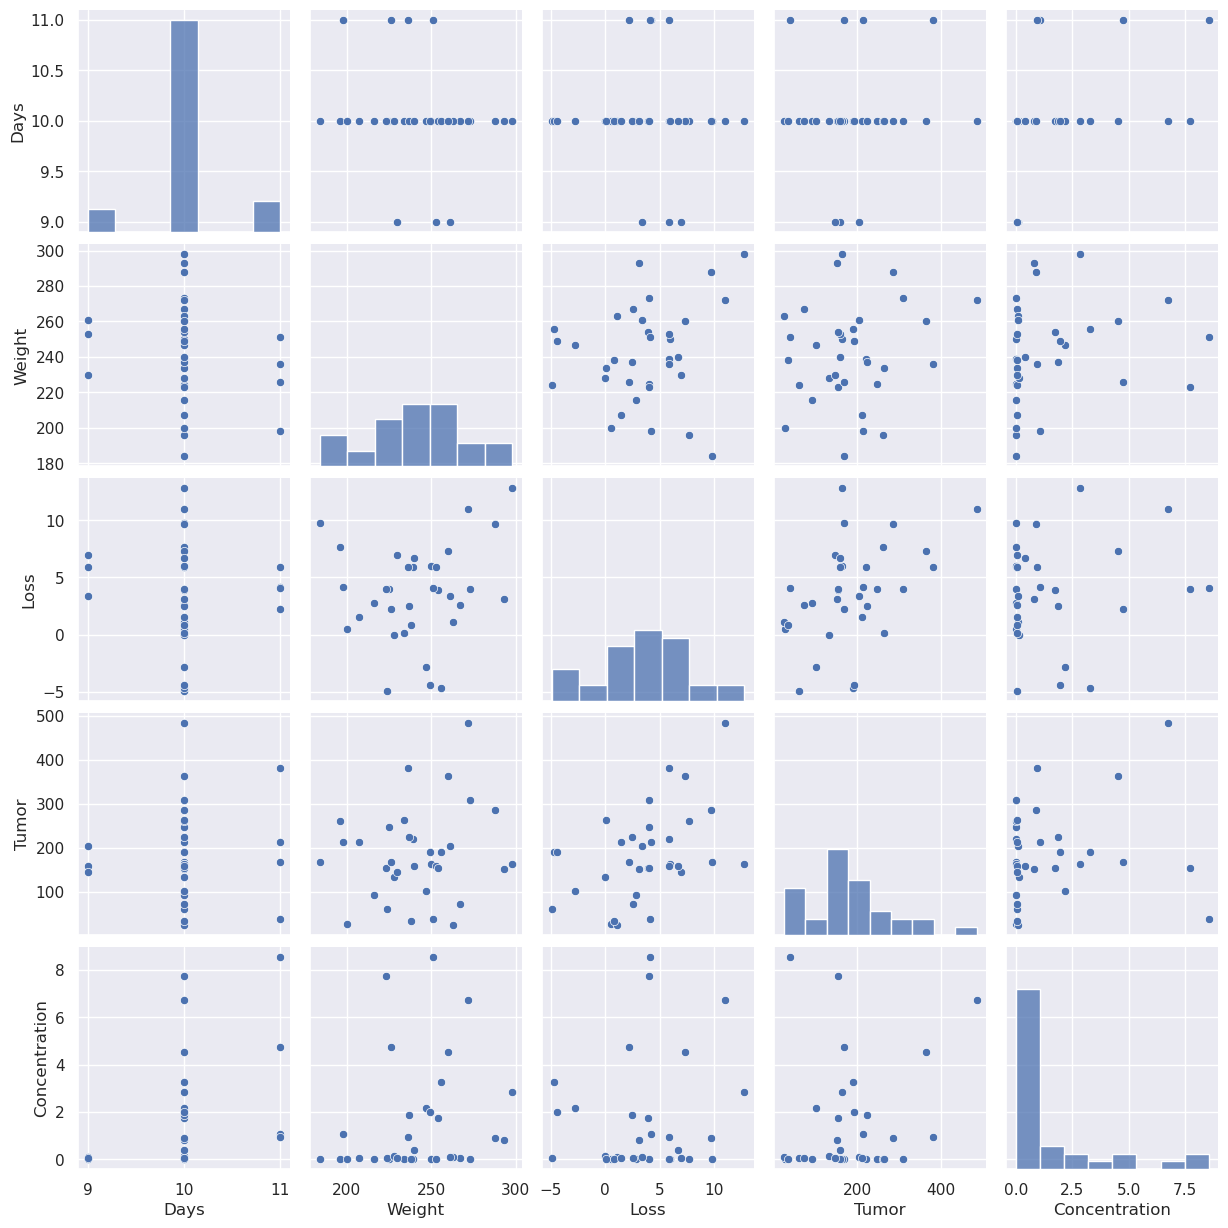

In [5]:
# a pairplot of the covariates shows at the very least that concentration should be logged
cols = ['Days', 'Weight', 'Loss', 'Tumor', 'Concentration']
g = sns.pairplot(df[cols])

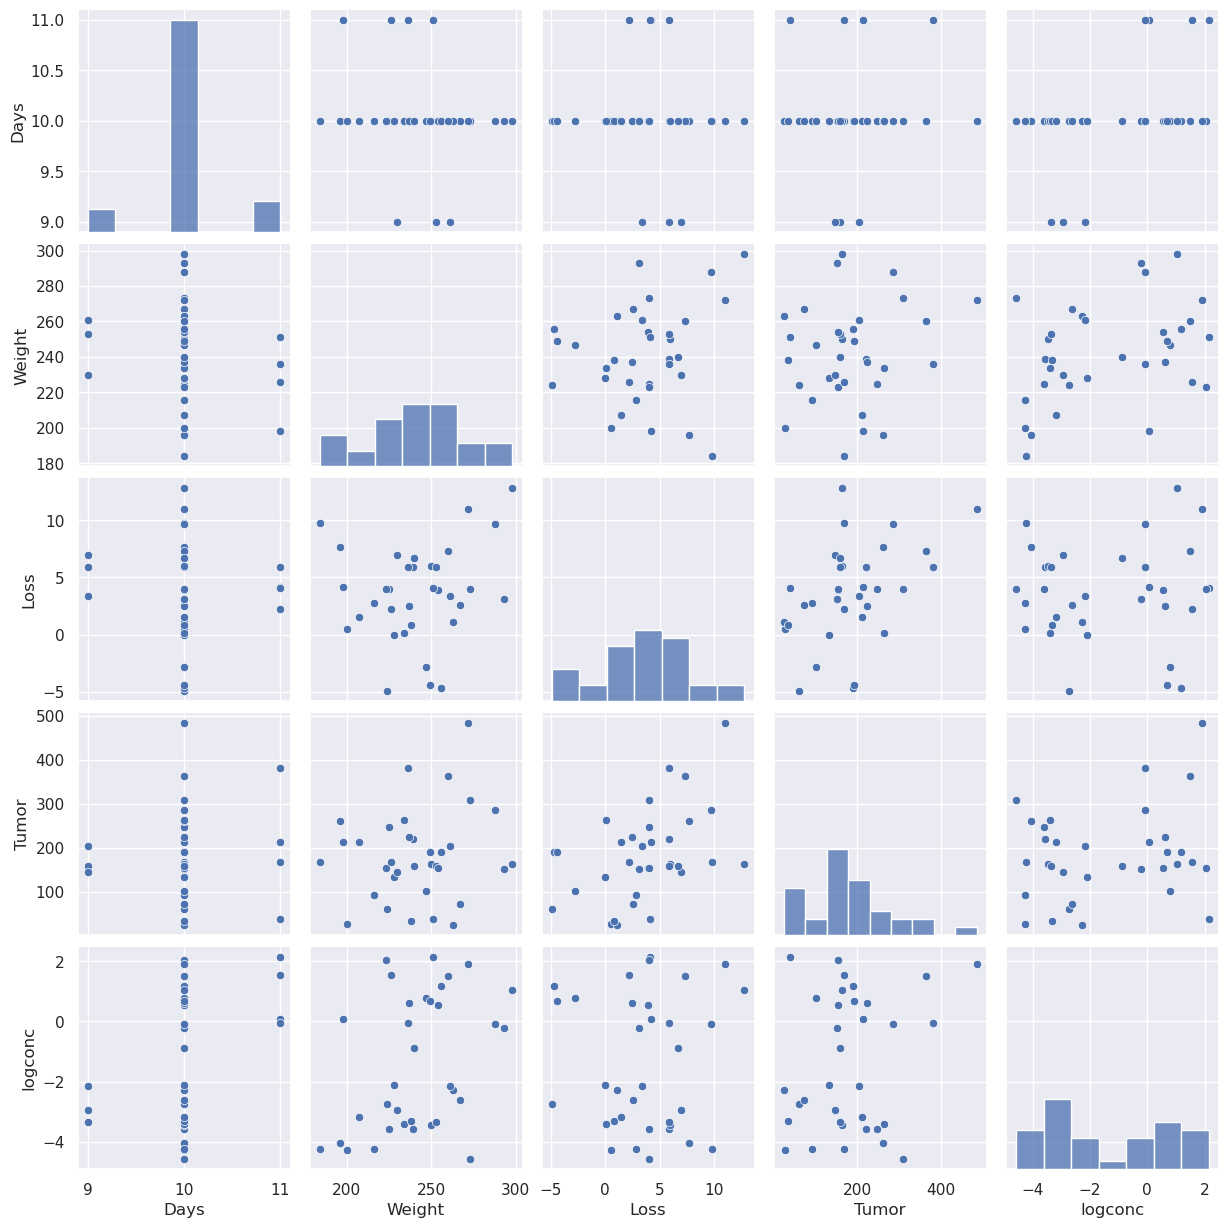

In [6]:
df['logconc'] = np.log(df['Concentration'])
cols = ['Days', 'Weight', 'Loss', 'Tumor', 'logconc']
g = sns.pairplot(df[cols])

**Days** clearly looks to have an effect, **Weight** (total weight) looks like it has an effect, but the effects of **Loss** and **Tumor** (weight loss and tumor weight) are not clear.  

We choose to fully hydrate the model as follows:
 
$\mu\{\log(Conc) | SAC, TRTMT, Days, FEM, weight, loss, tumor\} = SAC + TREAT + (SAC \times TREAT) + Days + FEM + weight + loss + tumor$

In [13]:
formula = (
    'np.log(Concentration) '
    '~ C(SAC, Treatment(reference=0.5)) '
    '+ C(TRTMNT, Treatment(reference="NS")) '
    '+ C(SAC, Treatment(reference=0.5)) * C(TRTMNT, Treatment(reference="NS")) '
    '+ C(Sex, Treatment(reference="Female")) '
    '+ Days + Weight + Loss + Tumor'
)
model = smf.ols(formula, data=df)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     np.log(Concentration)   R-squared:                       0.960
Model:                               OLS   Adj. R-squared:                  0.937
Method:                    Least Squares   F-statistic:                     41.92
Date:                   Thu, 13 Jun 2024   Prob (F-statistic):           6.45e-12
Time:                           13:19:39   Log-Likelihood:                -20.593
No. Observations:                     34   AIC:                             67.19
Df Residuals:                         21   BIC:                             87.03
Df Model:                             12                                         
Covariance Type:               nonrobust                                         
=======================================================================================================================================================
                                                                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                              -3.8367      3.391     -1.131      0.271     -10.889       3.215
C(SAC, Treatment(reference=0.5))[T.3.0]                                                 1.0155      0.400      2.541      0.019       0.184       1.846
C(SAC, Treatment(reference=0.5))[T.24.0]                                                4.3371      0.478      9.077      0.000       3.343       5.331
C(SAC, Treatment(reference=0.5))[T.72.0]                                                5.0106      0.455     11.013      0.000       4.064       5.957
C(TRTMNT, Treatment(reference="NS"))[T.BD]                                              0.7960      0.379      2.100      0.048       0.008       1.584
C(Sex, Treatment(reference="Female"))[T.Male]                                           0.0013      0.373      0.003      0.997      -0.775       0.778
C(SAC, Treatment(reference=0.5))[T.3.0]:C(TRTMNT, Treatment(reference="NS"))[T.BD]      0.1798      0.552      0.326      0.748      -0.968       1.328
C(SAC, Treatment(reference=0.5))[T.24.0]:C(TRTMNT, Treatment(reference="NS"))[T.BD]    -0.3860      0.585     -0.659      0.517      -1.604       0.831
C(SAC, Treatment(reference=0.5))[T.72.0]:C(TRTMNT, Treatment(reference="NS"))[T.BD]     0.3791      0.569      0.666      0.513      -0.805       1.563
Days                                                                                   -0.0370      0.296     -0.125      0.902      -0.652       0.578
Weight                                                                                 -0.0006      0.005     -0.105      0.918      -0.012       0.011
Loss                                                                                   -0.0595      0.030     -1.957      0.064      -0.123       0.004
Tumor                                                                                   0.0016      0.001      1.265      0.220      -0.001       0.004
==============================================================================
Omnibus:                        5.848   Durbin-Watson:                   1.698
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                6.387
Skew:                          -0.301   Prob(JB):                       0.0410
Kurtosis:                       5.036   Cond. No.                     1.10e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.1e+04. 

# Scatterplot of residuals vs fitted values from the fit of logged response on a rich model for explanatory variables

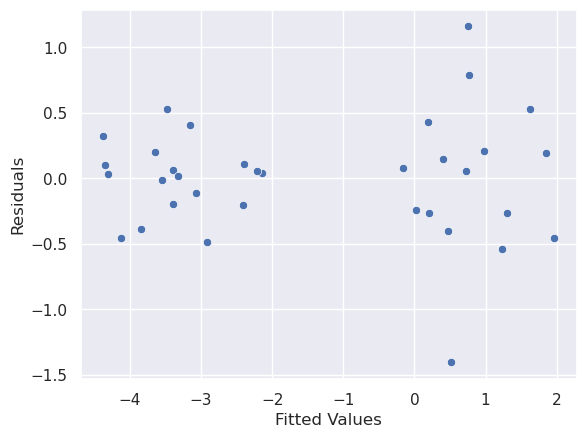

In [14]:
ax = sns.scatterplot(x=results.fittedvalues, y=results.resid)
_ = ax.set_xlabel('Fitted Values')
_ = ax.set_ylabel('Residuals')

In [15]:
# there seem to be two notable residuals
df[abs(results.resid) > 1]

,Brain,Liver,SAC,TRTMNT,Days,Sex,Weight,Loss,Tumor,Concentration,logconc
30,6250,928,72.000,NS,10,Male,272,11.000,484,6.735,1.907
33,1334,3242,72.000,NS,10,Female,240,6.700,159,0.411,-0.888


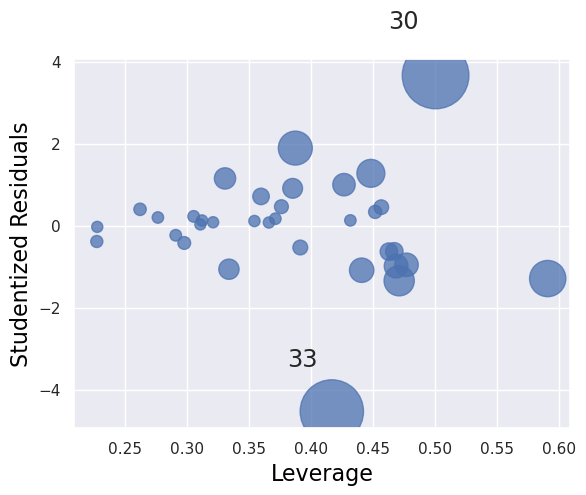

In [19]:
# an influence plot shows the same
fig, ax = plt.subplots()
_ = sm.graphics.influence_plot(results, ax=ax)
_ = ax.set_title('')

# Partial Residual Plots

In [ ]:
model_reduced = sm.ols('')

In [ ]:
formula = 'np.log(Concentration) ~ C(Time) + Treatment'
rmodel = smf.ols(formula, data=df)
rmodel_fit = rmodel.fit()
rmodel_fit.summary()

In [ ]:
ddof = (rmodel_fit.df_resid - model_fit.df_resid)
fvalue = ((rmodel_fit.ssr - model_fit.ssr) / ddof) / model_fit.mse_resid
scipy.stats.f.sf(ddof, model_fit.df_resid, fvalue)

This is reasonable evidence that the covariates can be dropped.

In [ ]:
np.exp(rmodel_fit.params['Treatment[T.NS]'])

The coefficient of the indicator variable for the blood-brain placebo treatment is -0.7968, so expressed in accordance with the interpretation for log-transformed responses, the median ratio of antibody concentration in the brain tumor to antibody concentration in the liver is estimated to be exp(-0.7968)= 0.4508 times less for the control than for the blood-brain barrier diffusion treatment.  Stated alternatively, the median concentration is expected to be  1/0.4508 = 2.2183 times greater the the diffusion treatment.

# Statistical Conclusion
The median antibody concentration in the tumor (relative to that in the liver) was estimated to be 2.22 times as much for rats receiving the barrier disruption infusion than for those receiving the control infusion (95% confidence interval, from 1.56 to 3.15 times as much).  This multiplicative effect appears to be constant between 1/2 and 72 hours after the infusion (the $p$-value for a test of interaction between treatment and sacrifice time is 0.92 , from an $F$-test on 3 and 26 degrees of freedom.


# Scope of Inference
One hitch in this study is that randomization was not used to assign rats to treatment groups.  This oversight raises the possibility that the estimated relationships might be related to confounding variables over which the experimenter exercised no control.  Including the measured covariates in the model helps alleviate some concern, and the results appear to no have been affected by these potential confounding variables.  Nevertheless, causal implications can only be justified on the tenuous assumption that the assignment method used was as effect-neutral as a random assignment would have been.